<h1>EDA(Exploratory Data Analysis) and NLP(Natural Language Processing)</h1>

The objective of this notebook is to propose an analytical view of e-commerce relationship in Brazil. For this we will first go trough an exploratory data analysis using graphical tools to create self explanatory plots for better understanding what is behind braziian online purchasing. Finally we will look at customers reviews and implement Sentimental Analysis to make a text classification using Natural Language Process tools.
<h2>Importing Libraries</h2>

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
import datetime

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# LightGBM is a gradient boosting ensemble method that is used by the Train Using AutoML tool and is based on decision trees. As with other decision tree-based methods, LightGBM can be used for both classification and regression. LightGBM is optimized for high performance with distributed systems.
import lightgbm as lgb

<h2>Reading the Data</h2>

In [2]:
# Reading all the files
olist_customer = pd.read_csv('./archive/olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('./archive/olist_geolocation_dataset.csv')
olist_orders = pd.read_csv('./archive/olist_orders_dataset.csv')
olist_orders_items = pd.read_csv('./archive/olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('./archive/olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('./archive/olist_order_reviews_dataset.csv')
olist_products = pd.read_csv('./archive/olist_products_dataset.csv')
olist_sellers = pd.read_csv('./archive/olist_sellers_dataset.csv')

<h2>An overview from the data</h2>
Before creating a unique dataset with all useful information, let's look at the shape of each dataset, so we can be more assertive on how to use joining statements. 

In [3]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_orders_items, olist_order_payments, olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments', 'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a Dataframe with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

In [4]:
olist_customer.info()
olist_geolocation.info()
olist_orders.info()
olist_orders_items.info()
olist_order_payments.info()
olist_order_reviews.info()
olist_products.info()
olist_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  

<h2>Total Orders on E-commerce</h2>
We know that e-commerce is really a growing trend in a global perspective. Let's dive into the orders dataset to see how this trend can be presented in Brazil, at least on the dataset range.
</br></br>
Looking at the dataset columns, we can see orders with different `status` and with different timestamp columns like `purchase`, `approved`, `delivered` and `estimated delivery`. First, let's look at the status of the orders we have in this dataset.

In [5]:
df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')
df_orders

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date                customer_unique_id  \
0               2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
1               2018-08-13 00:00:00  af07308b275d755c9edb36a90c618231   
2               2018-09-04 00:00:00  3a653a41f6f9fc3d2a113cf8398680e8   
3               2017-12-15 00:00:00  7c142cf63193a1473d2e66489a9ae977   
4               2018-02-26 00:00:00  72632f0f9dd73dfee390c9b22eb56dd6   
...                             ...                               ...   
99436           2017-03-28 00:00:00  6359f309b166b0196dbf7ad2ac62bb5a   
99437           2018-03-02 00:00:00  da62f9e57a76d978d02ab5362c509660   
99438           2017-09-27 00:00:00  737520a9aad80b3fbbdad19b66b37b30   
99439           2018-02-15 00:00:00  5097a5312c8b157bb7be58ae360ef43c   
99440           2018-04-03 00:00:00  60350aa974b26ff12caad89e55993bd6   

       customer_zip_code_prefix            customer_city customer_state  
0                          3149                sao paulo             SP  
1                         47813                barreiras             BA  
2                         75265               vianopolis             GO  
3                         59296  sao goncalo do amarante             RN  
4                          9195              santo andre             SP  
...                         ...                      ...            ...  
99436                     12209      sao jose dos campos             SP  
994

<AxesSubplot:>

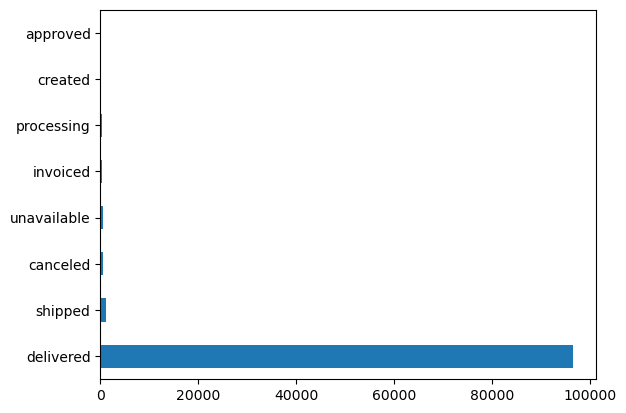

In [6]:
df_orders.order_status.value_counts().plot(kind='barh')

By the time this dataset was created, the highest amount of orders went from delivered ones. Only 3% of all orders came from the other status.
</br></br>Is that a growing trend on e-commmerce in Brazil? How can we descrive a complete sceanrio?

For the next plots, let's dive into the real evolution of e-commerce in terms of purchase orders. For this, we have to extract some info on the `order_purchase_timestamp` following the topics:
</br>
    1. Transform timestamp columns;</br>
    2. Extract time attributes from these datetime columns (year, month, day, day of week and hour);</br>
    3. Evaluate the e-commerce scenario using this attributes.

In [7]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_estimated_delivery_date']

for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hour_bins = [-0.1, 6, 12, 18, 23]
hour_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hour_bins, labels=hour_labels)

# New DataFrame after transformations
df_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  \
0                      3149                sao paulo             SP   
1                     47813                barreiras             BA   
2                     75265               vianopolis             GO   
3                     59296  sao goncalo do amarante             RN   
4                      9195              santo andre             SP   

   order_purchase_year  order_purchase_month order_purchase_month_name  \
0                 2017                    10                       Oct   
1                 2018                     7                       Jul   
2                 2018                     8                       Aug   
3                 2017                    11                       Nov   
4                 2018                     2                       Feb   

  order_purchase_year_month order_purchase_date  order_purchase_day  \
0                    201710            20171002                   2   
1                    201807            20180724                  24   
2                    201808            20180808                   8   
3                    201711            20171118                  18   
4                    201802            20180213                  13   

   order_purchase_dayofweek order_purchase_dayofweek_name  \
0                         0                           Mon   
1                         1                           Tue   
2                         2                           Wed   
3                         5                           Sat   
4                         1                           Tue   

   order_purchase_hour order_purchase_time_day  
0                   10                 Morning  
1                   20                   Night  
2                    8                 Morning  
3                   19                   Night  
4                   21                   Night

So now we can purpose a complete analysis on orders amount of brazilian e-commerce during the period of the dataset. For that let's plot three graphs using a `GridSpec` with the aim answear the following questions:
</br></br>
    1. Is there any growing trend on brazilian e-commerce?</br>
    2. On what day of week brazilians customers tend to do online purchasing?</br>
    3. What time brazilians customers tend do buy (Dawn, Morning, Afternoon or Night)?

/home/neel/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/home/neel/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/tmp/ipykernel_21433/1921417532.py:34: UserWarning:

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.



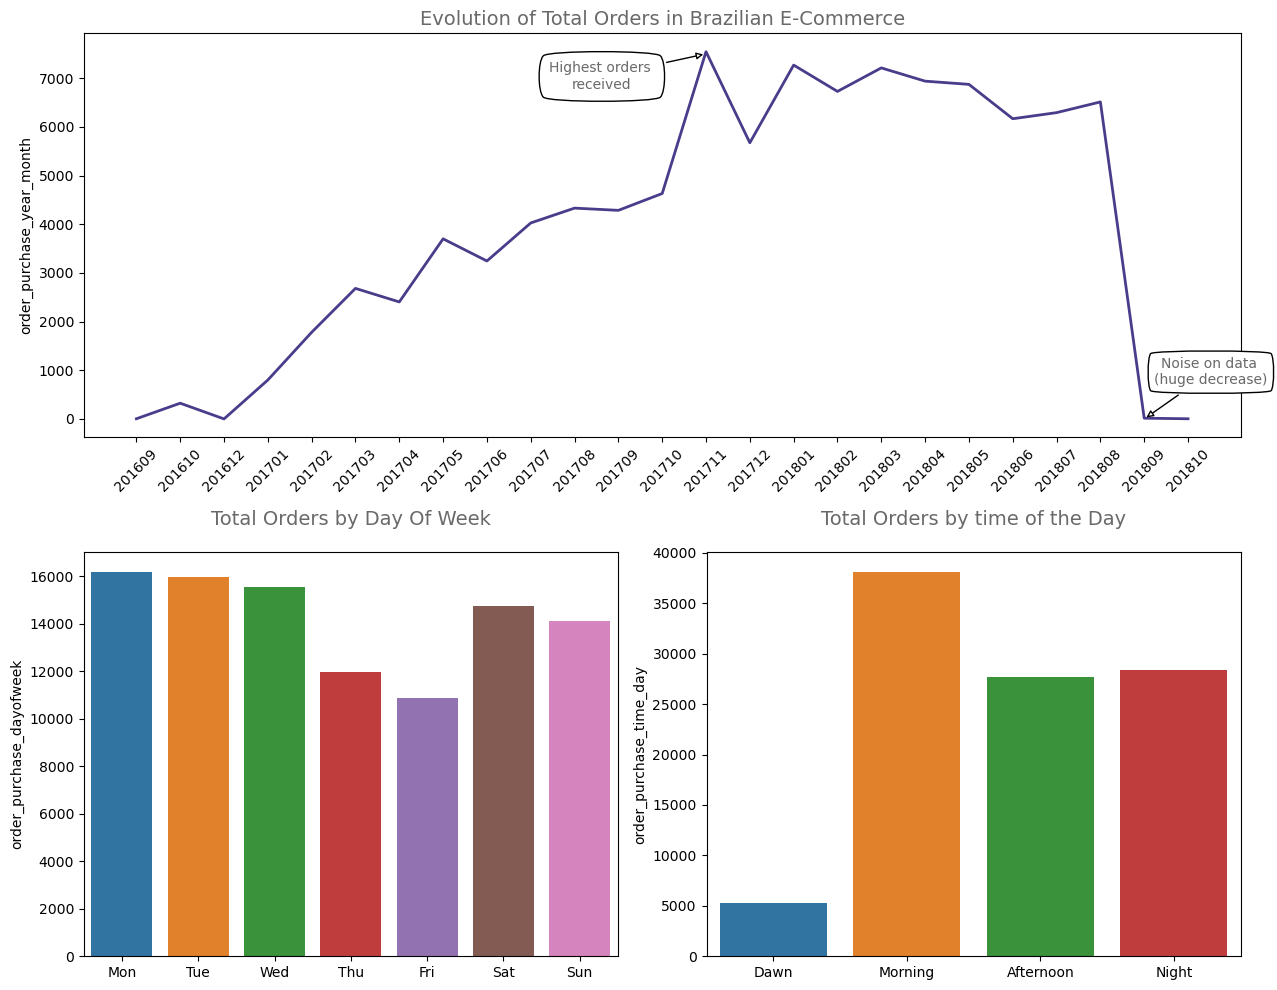

In [8]:
fig = plt.figure(constrained_layout = True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot((gs[0, :]))
ax2 = fig.add_subplot((gs[1, 0]))
ax3 = fig.add_subplot((gs[1, 1]))

# Lineplot - Evolution of e-commerce orders along time
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# BarChart - Total of orders by day of week
sns.barplot(df_orders.order_purchase_dayofweek.unique(), df_orders.order_purchase_dayofweek.value_counts() ,ax=ax2)
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day Of Week', size=14, color='dimgrey', pad=20)

# BarChart - Total of orders by time of day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkkorange', 'purple']
sns.barplot(df_orders.order_purchase_time_day.unique(), df_orders.order_purchase_time_day.value_counts(), ax=ax3)
ax3.set_title('Total Orders by time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

By the chart above we can conclude:

* E-commerce on Brazil really has a growing trend along the time. We can see some seasonality with peaks at specific months, but in general we can see clear that customers are more prone to buy things online than before.
* Monday are the prefered day for brazilian's customers and they tend to buy more at afternoons.

_Obs: we have a sharp decrease between August 2018 and September 2018 and maybe the origin of that is related to noise on data. For further comparison between 2017 and 2018, let's just consider orders between January and August in both years_
</br>
<h2>E-commerce: a comparision between 2017 and 2018</h2>

In [9]:
df_orders

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...            ...                      ...                 ...   
99436    delivered      2017-03-09 09:54:05 2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date                customer_unique_id  \
0                        2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                        2018-08-13  af07308b275d755c9edb36a90c618231   
2                        2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                        2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                        2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   
...                             ...                               ...   
99436                    2017-03-28  6359f309b166b0196dbf7ad2ac62bb5a   
99437                    2018-03-02  da62f9e57a76d978d02ab5362c509660   
99438                    2017-09-27  737520a9aad80b3fbbdad19b66b37b30   
99439                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
99440                    2018-04-03  60350aa974b26ff12caad89e55993bd6   

       customer_zip_code_prefix            customer_city customer_state  \
0                          3149                sao paulo             SP   
1                         47813                barreiras             BA   
2                         75265               vianopolis             GO   
3                         59296  sao goncalo do amarante             RN   
4                          9195              santo andre             SP   
...                         ...                      ...            ...   
99436                     12209      sao jose dos campos             SP   
99437  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


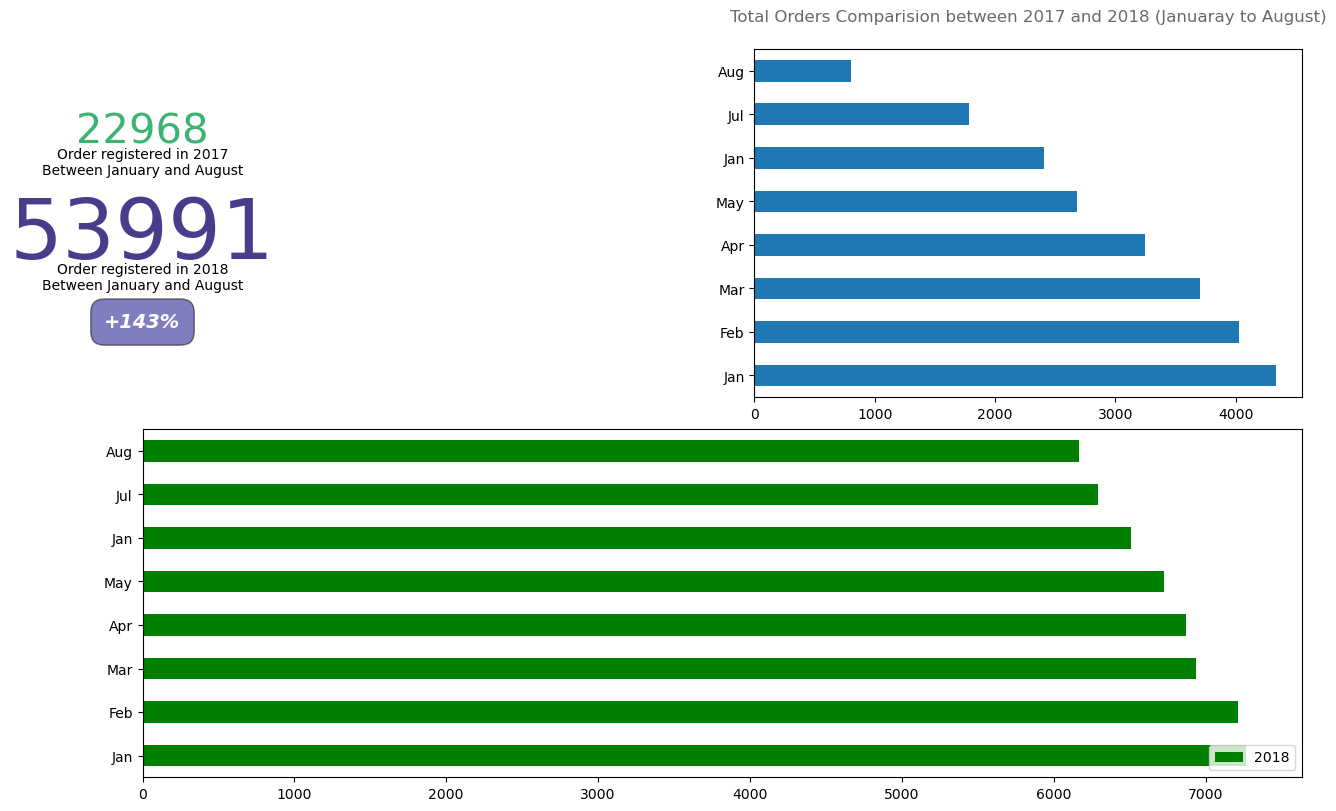

In [10]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 8))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])
ax3 = fig.add_subplot(gs[1, 0:])


# Annotation - Grown on e-commerece orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
y17 = df_orders.query('order_purchase_year == 2017 & order_purchase_month <= 8')
y18 = df_orders.query('order_purchase_year == 2018 & order_purchase_month <= 8')

year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100*(1+year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=30, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'Order registered in 2017\nBetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'Order registered in 2018\nBetween January and August', fontsize=10, ha='center')

signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold', bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar Chart - Comparision between monthly sales between 2017 and 2018

y17.order_purchase_year_month.value_counts().plot(kind='barh', ax=ax2, label='2017')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jan', 'Jul', 'Aug']
ax2.set_yticklabels(month_label)
ax2.set_title('Total Orders Comparision between 2017 and 2018 (Januaray to August)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')

y18.order_purchase_year_month.value_counts().plot(kind='barh', ax=ax3, label='2018', color='g')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jan', 'Jul', 'Aug']
ax3.set_yticklabels(month_label)
plt.legend(loc='lower right')
plt.show()

<h2>E-Commerce Around Brazil</h2>
For preparing the data to a workaround analysis on brazilian's states e-commerce, we will take the following steps:
</br>1. Merge the orders data to order_items data;
</br>2. Use an API (brazilian government) to return the region of each customer_state;
</br>3. Purpose useful charts to answear business questions.
</br>
* Brazilian APIs ans links for geolocation info:

        https://servicodados.ibge.gov.br/api/docs/localidades?versao=1

In [11]:
# Merging orders and order_items
df_orders_items = df_orders.merge(olist_orders_items, how='left', on='order_id')

# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

In [12]:
br_info

id sigla                 nome   nome_regiao
0    11    RO             Rondônia         Norte
2    12    AC                 Acre         Norte
4    13    AM             Amazonas         Norte
8    14    RR              Roraima         Norte
10   15    PA                 Pará         Norte
16   16    AP                Amapá         Norte
18   17    TO            Tocantins         Norte
20   21    MA             Maranhão      Nordeste
25   22    PI                Piauí      Nordeste
29   23    CE                Ceará      Nordeste
36   24    RN  Rio Grande do Norte      Nordeste
40   25    PB              Paraíba      Nordeste
44   26    PE           Pernambuco      Nordeste
49   27    AL              Alagoas      Nordeste
52   28    SE              Sergipe      Nordeste
55   29    BA                Bahia      Nordeste
62   31    MG         Minas Gerais       Sudeste
74   32    ES       Espírito Santo       Sudeste
78   33    RJ       Rio de Janeiro       Sudeste
84   35    SP            São Paulo       Sudeste
99   41    PR               Paraná           Sul
109  42    SC       Santa Catarina           Sul
115  43    RS    Rio Grande do Sul           Sul
122  50    MS   Mato Grosso do Sul  Centro-Oeste
126  51    MT          Mato Grosso  Centro-Oeste
131  52    GO                Goiás  Centro-Oeste
136  53    DF     Distrito Federal  Centro-Oeste

In [13]:

# Threting geolocation outside brazilian map

# Brazils most Northern spot is at 5 deg 16' 27.8" N latitude.;
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
# It's most western spot is at 73 deg, 58' 58.19"W long
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
# It's most southern spot is at 33 deg, 45' 04.21" S Latitude
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
# It's most Eastern spot is 34 deg, 47' 35.33" W Long
geo_perp = geo_prep[geo_prep.geolocation_lng <= -34.793146722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df_orders_items.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2018-08-13  af07308b275d755c9edb36a90c618231   
2                    2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                    2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                    2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  \
0                      3149                sao paulo             SP   
1                     47813                barreiras             BA   
2                     75265               vianopolis             GO   
3                     59296  sao goncalo do amarante             RN   
4                      9195              santo andre             SP   

   order_purchase_year  order_purchase_month order_purchase_month_name  \
0                 2017                    10                       Oct   
1                 2018                     7                       Jul   
2                 2018                     8                       Aug   
3                 2017                    11                       Nov   
4                 2018                     2                       Feb   

  order_purchase_year_month order_purchase_date  order_purchase_day  \
0                    201710            20171002                   2   
1                    201807            20180724                  24   
2                    201808            20180808                   8   
3                    201711            20171118                  18   
4                    201802            20180213                  13   

   order_purchase_dayofweek order_purchase_dayofweek_name  \
0                         0                           Mon   
1                         1                           Tue   
2                         2                           Wed   
3                         5                           Sat   
4                         1                           Tue   

   order_purchase_hour order_purchase_time_day  order_item_id  \
0                   10                 Morning            1.0   
1                   20                   Night            1.0   
2                    8                 Morning            1.0   
3                   19                   Night            1.0   
4                   21                   Night            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0e7d26b

<h2>An overview od customer's order by region, state and city</h2>

In [14]:
# Filtering data between 201701 and 201808
df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Grouping data by region
df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

# Grouping data by city (top 10)
df_cities_group = df_orders_filt.groupby(by='geolocation_city', 
                                       as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

In [15]:
df_orders_filt

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3       949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4       ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                  ...                               ...   
113420  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
113421  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
113422  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
113423  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
113424  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp   order_approved_at  \
0         delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1         delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2         delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3         delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4         delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...             ...                      ...                 ...   
113420    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
113421    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
113422    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
113423    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
113424    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:13   
1               2018-07-26 14:31:00           2018-08-07 15:27:45   
2               2018-08-08 13:50:00           2018-08-17 18:06:29   
3               2017-11-22 13:39:59           2017-12-02 00:28:42   
4               2018-02-14 19:46:34           2018-02-16 18:17:02   
...                             ...                           ...   
113420          2018-02-07 23:22:42           2018-02-28 17:37:56   
113421          2017-08-28 20:52:26           2017-09-21 11:24:17   
113422          2018-01-12 15:35:03           2018-01-25 23:32:54   
113423          2018-01-12 15:35:03           2018-01-25 23:32:54   
113424          2018-03-09 22:11:59           2018-03-16 13:08:30   

       order_estimated_delivery_date                customer_unique_id  \
0                         2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                         2018-08-13  af07308b275d755c9edb36a90c618231   
2                         2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                         2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                         2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   
...                              ...                               ...   
113420                    2018-03-02  da62f9e57a76d978d02ab5362c509660   
113421                    2017-09-27  737520a9aad80b3fbbdad19b66b37b30   
113422                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
113423                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
113424                    2018-04-03  60350aa974b26ff12caad89e55993bd6   

        customer_zip_code_prefix            customer_city customer_state  \
0                           3149                sao paulo             SP   
1                          47813                barreiras             BA   
2                          75265               vianopolis             GO   
3                          59296  sao goncalo do amarante             RN   
4                           9195              santo andre             SP   
...                          ...                      ...            ...   
113420                     1

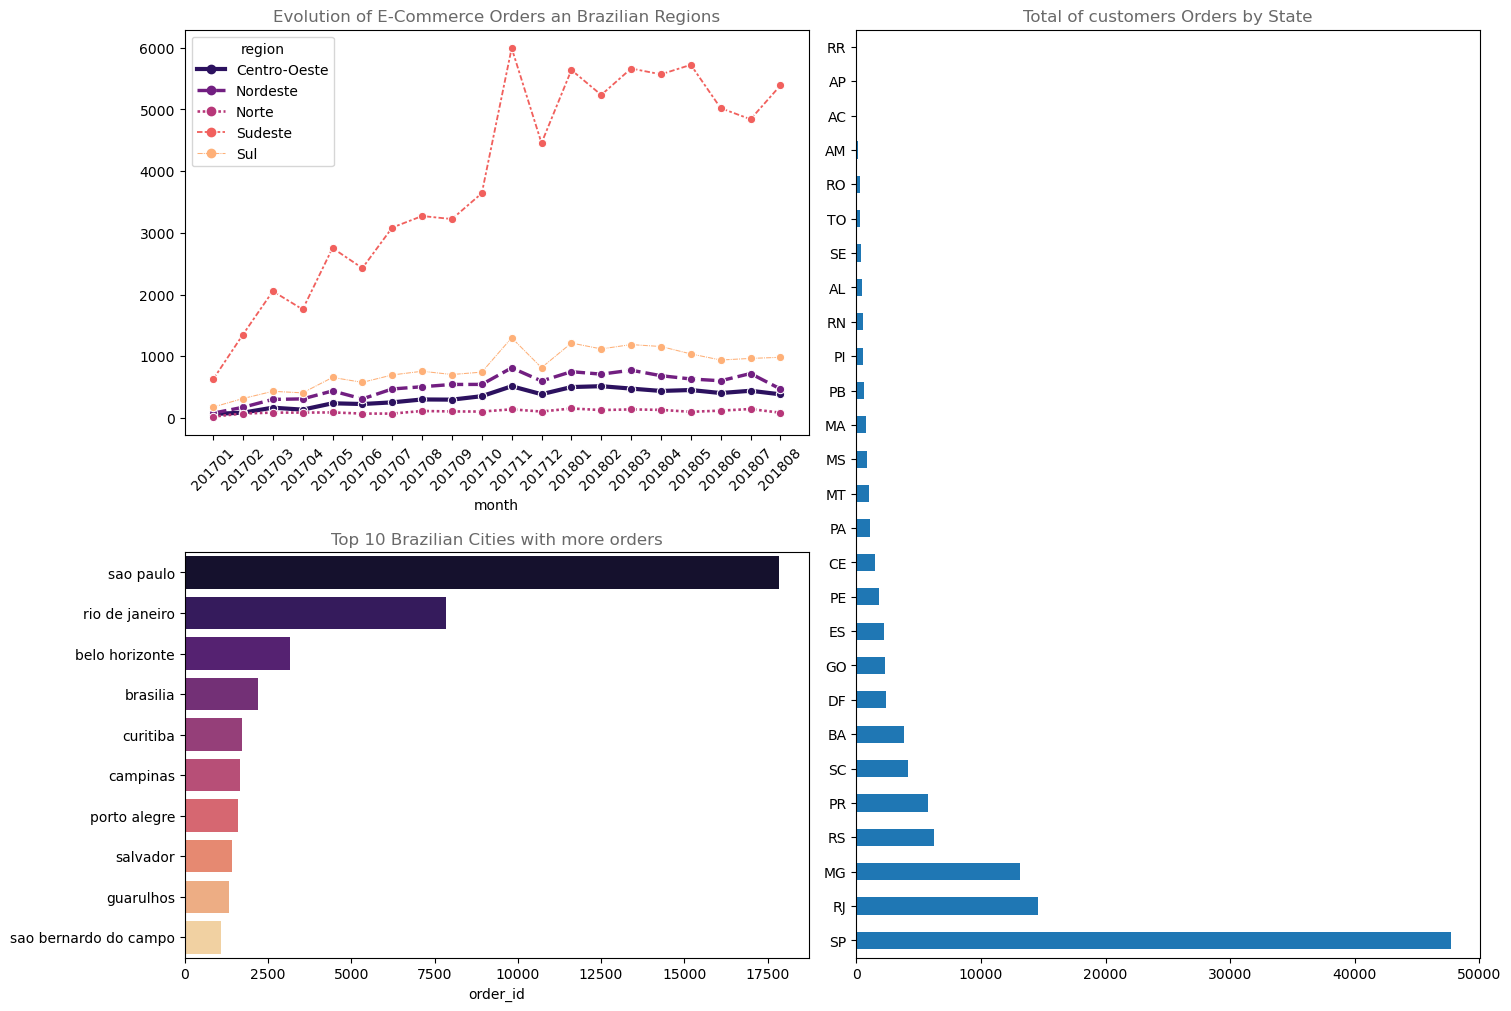

In [16]:
# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=df_regions_group, hue='region', size='region', style='region', palette='magma', markers=['o']*5)
ax1.set_title('Evolution of E-Commerce Orders an Brazilian Regions', size=12, color='dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    
# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='magma')
ax2.set_title('Top 10 Brazilian Cities with more orders', size=12, color='dimgrey')
ax2.set_ylabel('')

# Total orders by state
# df_orders_filt.value_counts().plot(kind='', y='customer_state', ax=ax3, palette='viridis')
df_orders_filt.customer_state.value_counts().plot(kind='barh', y='customer_state', ax=ax3)
ax3.set_title('Total of customers Orders by State', size=12, color='dimgrey')

plt.show()

<h2>How cutomers are distributed in Brazil? (a 30k asmple from 2018 in a map)</h2>

In [17]:
# Zipping locations
lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a map using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# plugin: FastMrkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

<h2>HeatMaps: A good view to where are the core of the brazilian e-commerce customers</h2>

</br>By the map we showed above, we have already the insight that the southeast of Brazil has the highest number of orders given through e-commerce. So, let's see it in a HeatMap!

In [18]:
# Grouping geolocation data for plotting a heatmap
heat_data = df_orders_filt.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

# Creating a map using folium
map1 = folium.Map(
    location=[-15, -50],
    zoom_start=4.0,
    tiles='cartodbdark_matter'
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data = heat_data,
    radius = 10,
    max_zoom= 13
).add_to(map1)

map1

**Nice!** Another good view is to use the folium plugin _[HeatMapWithTime](https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/HeatMapWithTime.ipynb)_ to see the evolution of e-commerce orders among time.

For [limitations](https://github.com/python-visualization/folium/issues/859) purpose (i.e. jupyter and Chrome limitations for total number of points shown at HeatMapWithTime, we will show the evolution of orders from January 2018 to July 2018)

Also, it's possible that the plugin HeatMapWithTime doesn't work properly from a [issue](https://github.com/python-visualization/folium/issues/1221) fixed on version 0.11 (it's seems that the version of the kernel is 0.10). It it is the case for you, just updating the version of folium library would fix it.

In [19]:
epoch_list = []
heatmap_evl_data = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201801)]
heatmap_evl_data = heatmap_evl_data[(heatmap_evl_data['order_purchase_year_month'].astype(int) <= 201807)]
time_index = heatmap_evl_data['order_purchase_year_month'].sort_values().unique()
for epoch in time_index:
    data_temp = heatmap_evl_data.query('order_purchase_year_month == @epoch')
    data_temp = data_temp.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count()
    data_temp = data_temp.sort_values(by='order_id', ascending=False).iloc[:, :3]
    epoch_list.append(data_temp.values.tolist())

# Creating a map using folium
map2 = folium.Map(
    location=[-15, -50],
    zoom_start=4.0,
    tiles='cartodbdark_matter'
)

# Plugin: HeatMapWithTime
HeatMapWithTime(
    name='Evolution of Orders in a Geolocation Persepective',
    data = epoch_list,
    radius = 10,
    index = list(time_index)
).add_to(map2)

map2

<h2>E-Commerce Impact on Economy</h2>
</br>Until now, we just answered questions on E-commerce scenario considering the number of orders received. We could see the volumetry amonth months, day of week, time of the day and even the geolocation states.

Now, we will analyze the money movemented by e-commerce by looking at order prices, freights and others.
<h2>How about the e-commerce sales? Did they grow up over time?</h2>
</br>For answering this question, let's first group our data in a way to look at evolution overall.

In [20]:
# Grouping data
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})

# Adding new columns for analysis
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg.head()

order_purchase_year order_purchase_year_month  order_id      price  \
0                 2017                    201701       966  120312.87   
1                 2017                    201702      1998  247303.02   
2                 2017                    201703      3041  374344.30   
3                 2017                    201704      2697  359927.23   
4                 2017                    201705      4176  506071.14   

   freight_value  price_per_order  freight_per_order  
0       16875.62       124.547484          17.469586  
1       38977.60       123.775285          19.508308  
2       57704.29       123.099079          18.975432  
3       52495.01       133.454664          19.464223  
4       80119.81       121.185618          19.185778

/tmp/ipykernel_21433/2625870826.py:56: UserWarning:

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.



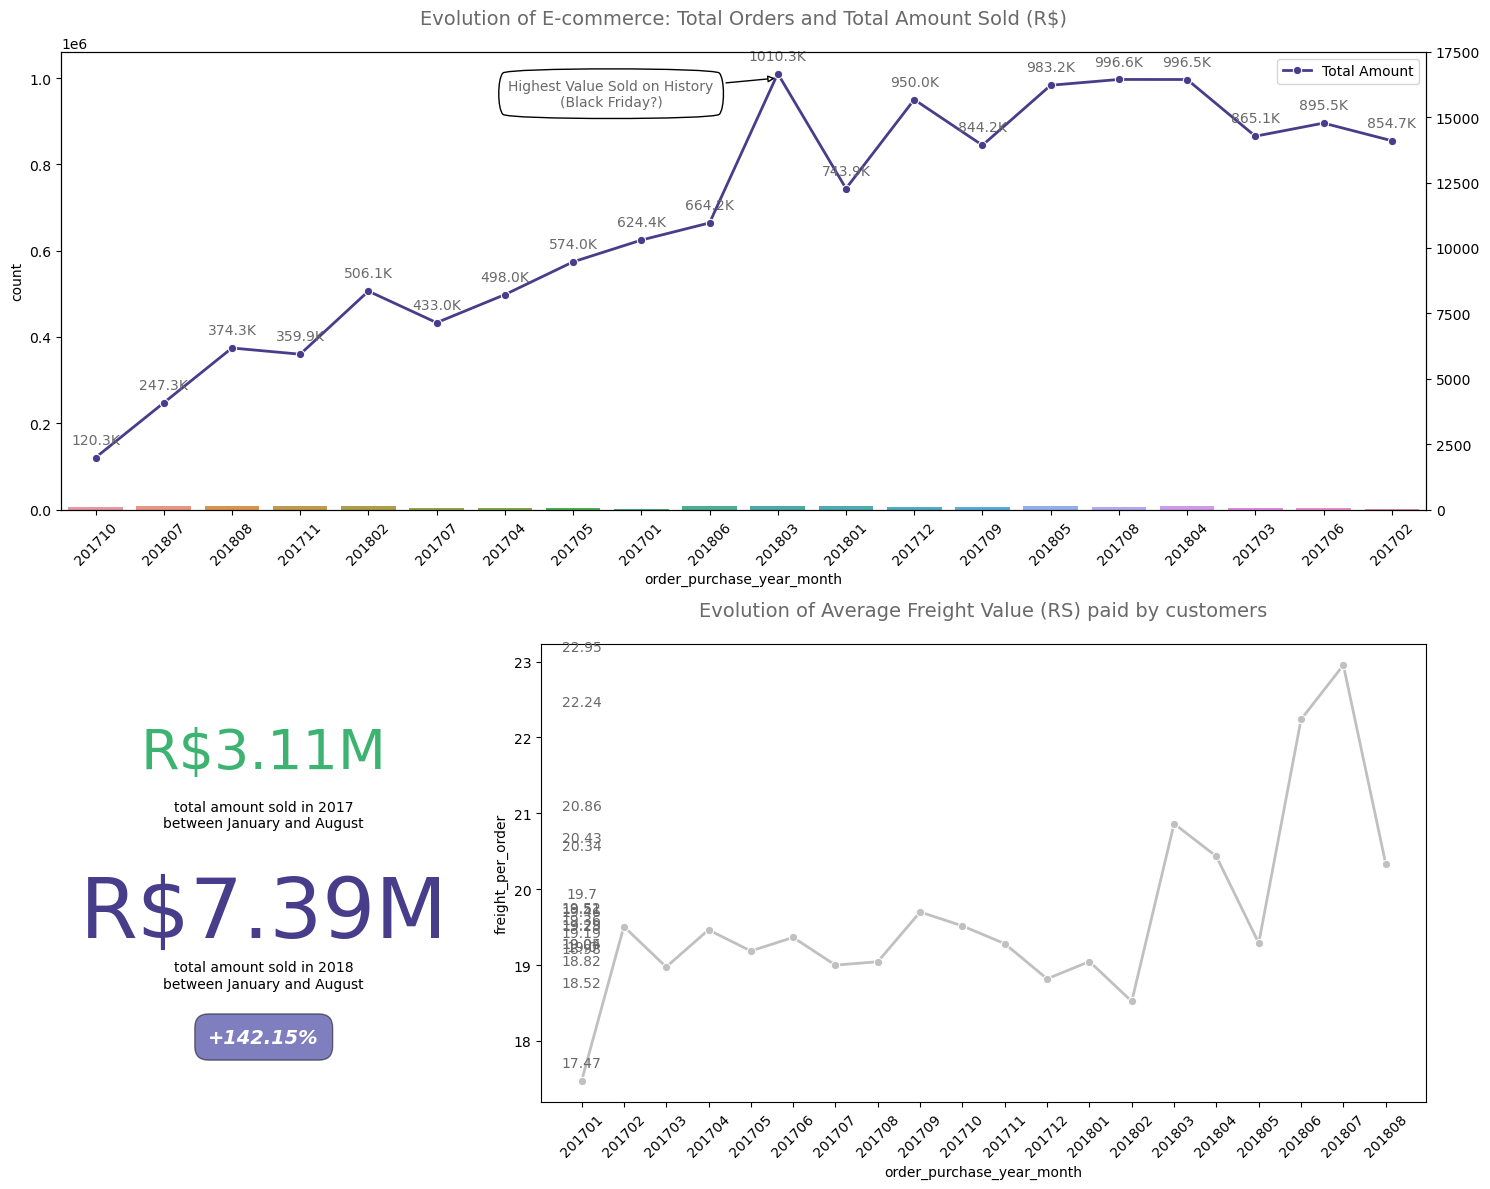

In [21]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='order_purchase_year_month', y='price', ax=ax1, data=df_month_aggreg, linewidth=2, color='darkslateblue', marker='o', label='Total Amount')
sns.countplot(data=df_orders_filt, x='order_purchase_year_month', ax=ax1)
ax1_twx = ax1.twinx()
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# Customize the first plot
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
count=0
for y in df_month_aggreg.price.to_list():
    ax1.annotate(str(round(y/1000, 1))+'K', xy=(count, y), textcoords='offset points', xytext=(0, 10), ha='center', color='dimgrey')
    count=count+1
ax1.annotate(f'Highest Value Sold on History\n(Black Friday?)', (10, 1000000), xytext=(-120, -20),
             textcoords='offset points', bbox=dict(boxstyle='round4', fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, color='dimgrey', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (sold_2017 / sold_2018)
ax2.text(0.50, 0.73, 'R$' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.60, 'total amount sold in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.50, 0.36, 'R$' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, 'total amount sold in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolutoin of mean frieght value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=df_month_aggreg, linewidth=2,
             color='silver', marker='o', ax=ax3)

for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
count=0
for y in df_month_aggreg.freight_per_order.to_list():
    ax3.annotate(round(y, 2), xy=(count, y), textcoords='offset points', xytext=(0, 10),
                 ha='center', color='dimgrey')
ax3.set_title('Evolution of Average Freight Value (RS) paid by customers', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

In [22]:
df_orders_filt

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2       47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3       949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4       ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                  ...                               ...   
113420  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
113421  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
113422  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
113423  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
113424  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

       order_status order_purchase_timestamp   order_approved_at  \
0         delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1         delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2         delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3         delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4         delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...             ...                      ...                 ...   
113420    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
113421    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
113422    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
113423    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
113424    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

       order_delivered_carrier_date order_delivered_customer_date  \
0               2017-10-04 19:55:00           2017-10-10 21:25:13   
1               2018-07-26 14:31:00           2018-08-07 15:27:45   
2               2018-08-08 13:50:00           2018-08-17 18:06:29   
3               2017-11-22 13:39:59           2017-12-02 00:28:42   
4               2018-02-14 19:46:34           2018-02-16 18:17:02   
...                             ...                           ...   
113420          2018-02-07 23:22:42           2018-02-28 17:37:56   
113421          2017-08-28 20:52:26           2017-09-21 11:24:17   
113422          2018-01-12 15:35:03           2018-01-25 23:32:54   
113423          2018-01-12 15:35:03           2018-01-25 23:32:54   
113424          2018-03-09 22:11:59           2018-03-16 13:08:30   

       order_estimated_delivery_date                customer_unique_id  \
0                         2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                         2018-08-13  af07308b275d755c9edb36a90c618231   
2                         2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8   
3                         2017-12-15  7c142cf63193a1473d2e66489a9ae977   
4                         2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6   
...                              ...                               ...   
113420                    2018-03-02  da62f9e57a76d978d02ab5362c509660   
113421                    2017-09-27  737520a9aad80b3fbbdad19b66b37b30   
113422                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
113423                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c   
113424                    2018-04-03  60350aa974b26ff12caad89e55993bd6   

        customer_zip_code_prefix            customer_city customer_state  \
0                           3149                sao paulo             SP   
1                          47813                barreiras             BA   
2                          75265               vianopolis             GO   
3                          59296  sao goncalo do amarante             RN   
4                           9195              santo andre             SP   
...                          ...                      ...            ...   
113420                     1

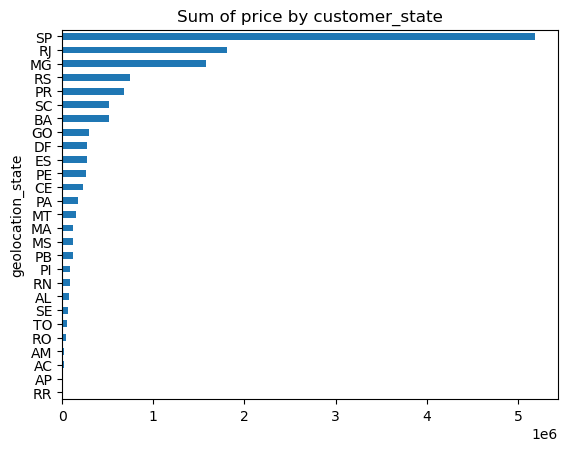

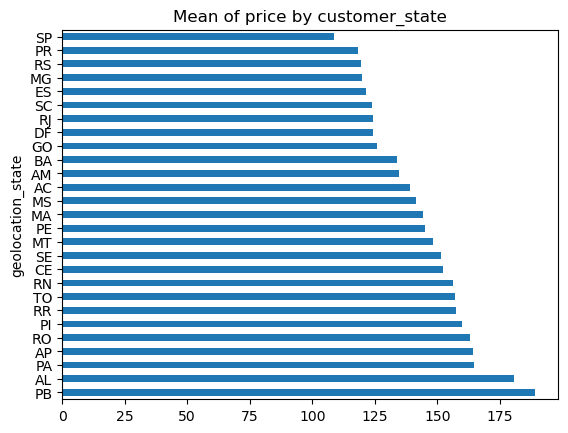

In [23]:

df_mean_group = df_orders_filt.groupby('geolocation_state')
df_mean_price = df_mean_group.agg({'price': 'sum', 'order_id': 'count'})

price_df = df_mean_price['price'].sort_values()
price_df.plot(kind='barh', title='Sum of price by customer_state')
plt.show()

df_mean_price['mean_price_state'] = (df_mean_price['price'] / df_mean_price['order_id'])
df_mean_price = df_mean_price['mean_price_state'].sort_values(ascending=False)
df_mean_price.plot(kind='barh', title='Mean of price by customer_state')
plt.show()

It's very important to see how some states have a high amount sold and a low price per order. If we look at SP (Sao Paulo) for example, it's possible to see that it is the state with most valuable state for e-commerce(5,188,099 sold) but it also where customers pay less per order(110.0 per order)
<h2>How about the frieght?</h2>

/tmp/ipykernel_21433/1698340050.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



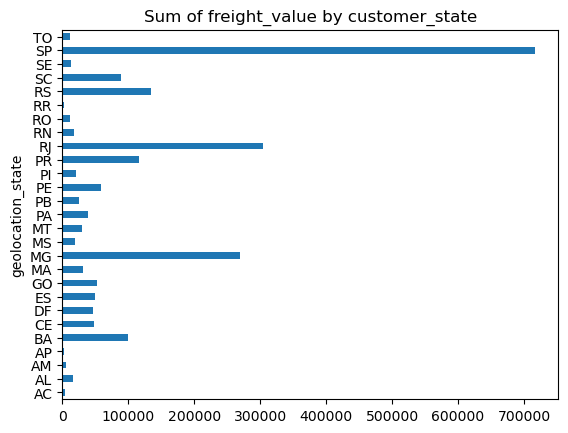

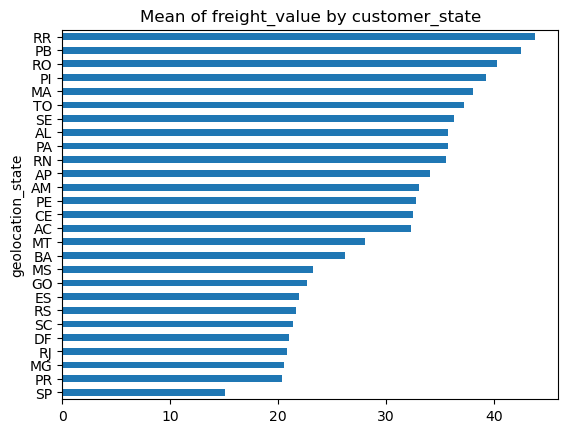

In [24]:
df_order_freight = df_orders_filt.groupby('geolocation_state')
df_order_freight = df_order_freight['order_id', 'geolocation_state', 'freight_value']
df_order_freight = df_order_freight.agg({'freight_value': 'sum', 'order_id': 'count'})
df_order_freight.freight_value.plot(kind='barh', title='Sum of freight_value by customer_state')
plt.show()

df_order_freight['mean_freight'] = df_order_freight['freight_value'] / df_order_freight['order_id']
df_order_freight = df_order_freight['mean_freight'].sort_values()
df_order_freight.plot(kind='barh', title='Mean of freight_value by customer_state')
plt.show()

Here we can get insights about the customers states with highest mean freight value. For example, customers in Roraima (RR), Paraíba (PB), Rondônia (RO) and Acre (AC) normaly pays more than anyone on freights.
<h2>What are the best states to buy in Brazil? An analysis on sales, freight and delivery</h2>

In [25]:
# df_orders_filt = df_orders_filt.reindex()

In [73]:
import datetime

def calc_delivery_days(purchaseDate, deliveredDate):
    delta = datetime.timedelta(days=1)
    exce=0
    avg=0
    tmp = []
    for i in range(0, len(purchaseDate)):
        CalcWorkingDays = 0
        try:
            t1 = datetime.date(purchaseDate[i].year, purchaseDate[i].month, purchaseDate[i].day)
            t2 = datetime.date(deliveredDate[i].year, deliveredDate[i].month, deliveredDate[i].day)
            while(t1 <= t2):
                t1 += delta
                if(t1.weekday() < 5):
                    CalcWorkingDays = CalcWorkingDays + 1
            tmp.append(CalcWorkingDays)
            avg += CalcWorkingDays
        except:
            exce +=1
    if(exce!=0):
        avg = (avg/(len(purchaseDate)-exce))
    while(exce!=0):
        tmp.append(avg)
        exce -= 1
    return tmp

def calc_diff_days(estimatedDate, deliveredDate):
    delta = datetime.timedelta(days=1)
    exce = 0
    avg = 0
    tmp = []
    for i in range(0, len(estimatedDate)):
        CalcWorkingDays = 0
        try:
            t1 = datetime.date(estimatedDate[i].year, estimatedDate[i].month, estimatedDate[i].day)
            t2 = datetime.date(deliveredDate[i].year, deliveredDate[i].month, deliveredDate[i].day)
            if(t1>t2):
                while(t2 <= t1):
                    t2 += delta
                    if(t2.weekday() < 5):
                        CalcWorkingDays = CalcWorkingDays + 1
                tmp.append(-CalcWorkingDays)
                avg += CalcWorkingDays
            else:
                while(t1 <= t2):
                    t1 += delta
                    if(t1.weekday() < 5):
                        CalcWorkingDays = CalcWorkingDays + 1
                tmp.append(+CalcWorkingDays)
        except:
            exce +=1
    if(exce!=0):
        avg = (avg/(len(estimatedDate)-exce))
    while(exce!=0):
        tmp.append(avg)
        exce -= 1
    return tmp

# Calculating working days between purchasing, delivering and estimated delivery
purchasing = df_orders_filt['order_purchase_timestamp']
delivered = df_orders_filt['order_delivered_customer_date']
estimated = df_orders_filt['order_estimated_delivery_date']
df_orders_filt['time_to_delivery'] = calc_delivery_days(pd.to_datetime(purchasing), pd.to_datetime(delivered))
df_orders_filt['diff_estimated_delivery'] = calc_diff_days(pd.to_datetime(estimated), pd.to_datetime(delivered))

# Grouping data by state
states_avg_grouped = df_orders_filt.groupby(by='customer_state', as_index=False).mean()
states_freight_paid = states_avg_grouped.loc[:, ['customer_state', 'freight_value']]
states_time_to_delivery = states_avg_grouped.loc[:, ['customer_state', 'time_to_delivery']]
states_estimated_delivery = states_avg_grouped.loc[:, ['customer_state', 'diff_estimated_delivery']]

# Sorting data
states_freight_paid = states_freight_paid.sort_values(by='freight_value', ascending=False)
states_time_to_delivery = states_time_to_delivery.sort_values(by='time_to_delivery', ascending=False)
states_estimated_delivery = states_estimated_delivery.sort_values(by='diff_estimated_delivery')

In [74]:
sum(df_orders_filt['diff_estimated_delivery']) / len(df_orders_filt.diff_estimated_delivery)

-8.659569737974506

In [75]:
sum(df_orders_filt['time_to_delivery']) / len(df_orders_filt.time_to_delivery)

9.716325207114632